In [1]:
import pandas as pd
import numpy as np

In [71]:
listings_clean = pd.read_csv('../../airbnb/listings_clean.csv')
transaction = pd.read_csv('../../airbnb/transactions.csv')
review = pd.read_csv('../../airbnb/reviews.csv')
calendars = pd.read_csv('../../airbnb/calendar.csv')

/var/folders/qd/qsp0wq0d3jq0jg40yqt79ffw0000gn/T/ipykernel_15457/1077540962.py:2: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  transaction = pd.read_csv('../../airbnb/transactions.csv')


In [72]:
listings_clean['email_verified'] = listings_clean['host_verifications'].str.contains('email').replace({True: 1, False: 0})
listings_clean['phone_verified'] = listings_clean['host_verifications'].str.contains('phone').replace({True: 1, False: 0})
listings_clean['work_email_verified'] = listings_clean['host_verifications'].str.contains('work_email').replace({True: 1, False: 0})


### Customer

In [73]:
customer = review.loc[:, ['reviewer_id', 'reviewer_name']].rename(columns={'reviewer_id': 'cid', 'reviewer_name': 'name'})
customer = customer.drop_duplicates(subset=['cid'])
customer['name'] = customer['name'].str.replace('\n', '', regex=False)
customer['name'] = customer['name'].str.replace('\r', '', regex=False)
customer['name'] = customer['name'].str.replace('|', '', regex=False)
customer.to_csv('../../airbnb/sql/customer.csv', index=False, sep= '|', lineterminator='\r\n')

### Transactions

In [74]:
transactions = transaction.loc[:, ['id', 'reviewer_id', 'listing_id', 'start_date','end_date','total_price','comments']].rename(columns={'listing_id': 'property', 'id': 'tid', 'reviewer_id': 'customer', 'start_date': 'start_date', 'end_date': 'end_date', 'total_price': 'total_price', 'comments': 'review'})
transactions = transactions.drop_duplicates(subset=['tid'])
transactions['review'] = transactions['review'].str.replace('\n', '', regex=False)
transactions['review'] = transactions['review'].str.replace('\r', '', regex=False)
transactions['review'] = transactions['review'].str.replace('|', '', regex=False)
transactions.to_csv('../../airbnb/sql/transactions.csv', index=False, sep= '|',lineterminator='\r\n')

### Calendar

In [75]:
calendar = calendars.loc[:, ['listing_id', 'date', 'available', 'minimum_nights', 'maximum_nights', 'price', 'adjusted_price']].rename(columns={'listing_id': 'property', 'date': 'date', 'price': 'price', 'available': 'availability', 'minimum_nights': 'min_nights', 'maximum_nights': 'max_nights', 'adjusted_price': 'adjusted_price'})
calendar = calendar.drop_duplicates(subset=['property', 'date'])
calendar['availability'] = calendar['availability'].replace({'t': 1, 'f': 0})
calendar['price'] = calendar['price'].str.replace('$', '', regex=False)
calendar['price'] = calendar['price'].str.replace(',', '', regex=False)
calendar['price'] = calendar['price'].astype(float)
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace('$', '', regex=False)
calendar['adjusted_price'] = calendar['adjusted_price'].str.replace(',', '', regex=False)
calendar['adjusted_price'] = calendar['adjusted_price'].astype(float)
calendar['min_nights'] = calendar['min_nights'].fillna(1)
calendar['max_nights'] = calendar['max_nights'].fillna(365)
calendar.to_csv('../../airbnb/sql/calendar.csv', index=False, sep= '|',lineterminator='\r\n')

### Listing

In [76]:
# We removed room_type since it's included in property_type
listing = listings_clean.loc[:, ['id', 'name','description','neighbourhood_cleansed', 'neighborhood_overview', 'host_id','latitude','longitude', 'property_type', 'accommodates','bathrooms_text','bedrooms','beds','amenities']].rename(columns={'id': 'lid', 'name': 'name', 'description': 'description', 'neighbourhood_cleansed': 'neighbourhood', 'neighborhood_overview':'overview', 'host_id': 'host', 'latitude': 'latitude', 'longitude': 'longitude', 'property_type': 'property_type', 'accommodates': 'accommodates', 'bathrooms_text': 'bathrooms', 'bedrooms': 'bedrooms', 'beds': 'beds', 'amenities': 'amenities'})
listing = listing.drop_duplicates(subset=['lid'])
listing['beds'] = listing['beds'].fillna(0)
listing['bedrooms'] = listing['bedrooms'].fillna(0)
for col in ['name', 'description', 'neighbourhood','overview','bathrooms','amenities']:
    listing[col] = listing[col].str.replace('\r', '', regex=False)
    listing[col] = listing[col].str.replace('\n', '', regex=False)
    listing[col] = listing[col].str.replace('|', '', regex=False)
listing.to_csv('../../airbnb/sql/listing.csv', index=False, sep= '|',lineterminator='\r\n')

### Host

In [77]:
host = listings_clean.loc[:, ['host_id', 'host_name', 'host_since', 'host_location', 'host_about','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost', 'host_neighbourhood', 'email_verified', 'phone_verified', 'work_email_verified','host_identity_verified']].rename(columns={'host_id': 'hid', 'host_name': 'name', 'host_since': 'since', 'host_location': 'location', 'host_about': 'description','host_response_time': 'response_time','host_response_rate': 'response_rate','host_acceptance_rate': 'acceptance','host_is_superhost': 'is_super_host', 'host_neighbourhood': 'neighbourhood','host_identity_verified': 'identity_verified', 'email_verified': 'email_verified', 'phone_verified': 'phone_verified', 'work_email_verified': 'work_email_verified'})
host['response_rate'] = host['response_rate'].str.replace('%', '').astype(float)
host['acceptance'] = host['acceptance'].str.replace('%', '').astype(float)
host['response_rate'] = host['response_rate'].fillna(0)
host['acceptance'] = host['acceptance'].fillna(0)
host['response_rate'] = host['response_rate']/100
host['acceptance'] = host['acceptance']/100
host['is_super_host'] = host['is_super_host'].replace({'t': 1, 'f': 0})
host['identity_verified'] = host['identity_verified'].replace({'t': 1, 'f': 0})
host = host.drop_duplicates(subset=['hid'])
for col in ['name', 'location', 'description']:
    host[col]=host[col].str.replace('\r', '', regex=False)
    host[col]=host[col].str.replace('\n', '', regex=False)
    host[col]=host[col].str.replace('|', '', regex=False)
host.to_csv('../../airbnb/sql/host.csv', index=False, sep= '|',lineterminator='\r\n')

### Host_url

In [78]:
host_url = listings_clean.loc[:, ['host_id', 'host_url']].rename(columns={'host_id': 'hid', 'host_url': 'url'})
host_url = host_url.drop_duplicates(subset=['hid'])
host_url['url'] = host_url['url'].replace('\r', '')
host_url['url'] = host_url['url'].replace('\n', '')
host_url['url'] = host_url['url'].replace('|', '')
host_url.to_csv('../../airbnb/sql/host_url.csv', index=False, sep= '|',lineterminator='\r\n')

### Host_thumbnail

In [79]:
host_thumbnail = listings_clean.loc[:, ['host_id', 'host_thumbnail_url']].rename(columns={'host_id': 'hid', 'host_thumbnail_url': 'thumbnail'})
host_thumbnail = host_thumbnail.drop_duplicates(subset=['hid'])
host_thumbnail['thumbnail'] = host_thumbnail['thumbnail'].replace('\r', '', regex=False)
host_thumbnail['thumbnail'] = host_thumbnail['thumbnail'].replace('\n', '', regex=False)
host_thumbnail['thumbnail'] = host_thumbnail['thumbnail'].replace('|', '', regex=False)
host_thumbnail.to_csv('../../airbnb/sql/host_thumbnail.csv', index=False, sep= '|',lineterminator='\r\n')

### Host_picture

In [80]:
host_picture = listings_clean.loc[:, ['host_id', 'host_picture_url']].rename(columns={'host_id': 'hid', 'host_picture_url': 'picture'})
host_picture = host_picture.drop_duplicates(subset=['hid'])
host_picture['picture'] = host_picture['picture'].replace('\r', '', regex=False)
host_picture['picture'] = host_picture['picture'].replace('\n', '', regex=False)
host_picture['picture'] = host_picture['picture'].replace('|', '', regex=False)
host_picture.to_csv('../../airbnb/sql/host_picture.csv', index=False, sep= '|',lineterminator='\r\n')

### Listing_url

In [81]:
listing_url = listings_clean.loc[:, ['id', 'listing_url']].rename(columns={'id': 'lid', 'listing_url': 'url'})
listing_url = listing_url.drop_duplicates(subset=['lid'])
listing_url['url'] = listing_url['url'].replace('\r', '', regex=False)
listing_url['url'] = listing_url['url'].replace('\n', '', regex=False)
listing_url['url'] = listing_url['url'].replace('|', '', regex=False)
listing_url.to_csv('../../airbnb/sql/listing_url.csv', index=False, sep= '|',lineterminator='\r\n')

### Listing_picture

In [82]:
listing_picture = listings_clean.loc[:, ['id', 'picture_url']].rename(columns={'id': 'lid', 'picture_url': 'picture'})
listing_picture = listing_picture.drop_duplicates(subset=['lid'])
listing_picture['picture'] = listing_picture['picture'].replace('\r', '', regex=False)
listing_picture['picture'] = listing_picture['picture'].replace('\n', '', regex=False)
listing_picture['picture'] = listing_picture['picture'].replace('|', '', regex=False)
listing_picture.to_csv('../../airbnb/sql/listing_picture.csv', index=False, sep= '|',lineterminator='\r\n')

### Visualization

<AxesSubplot: title={'center': 'Number of listings per neighbourhood'}>

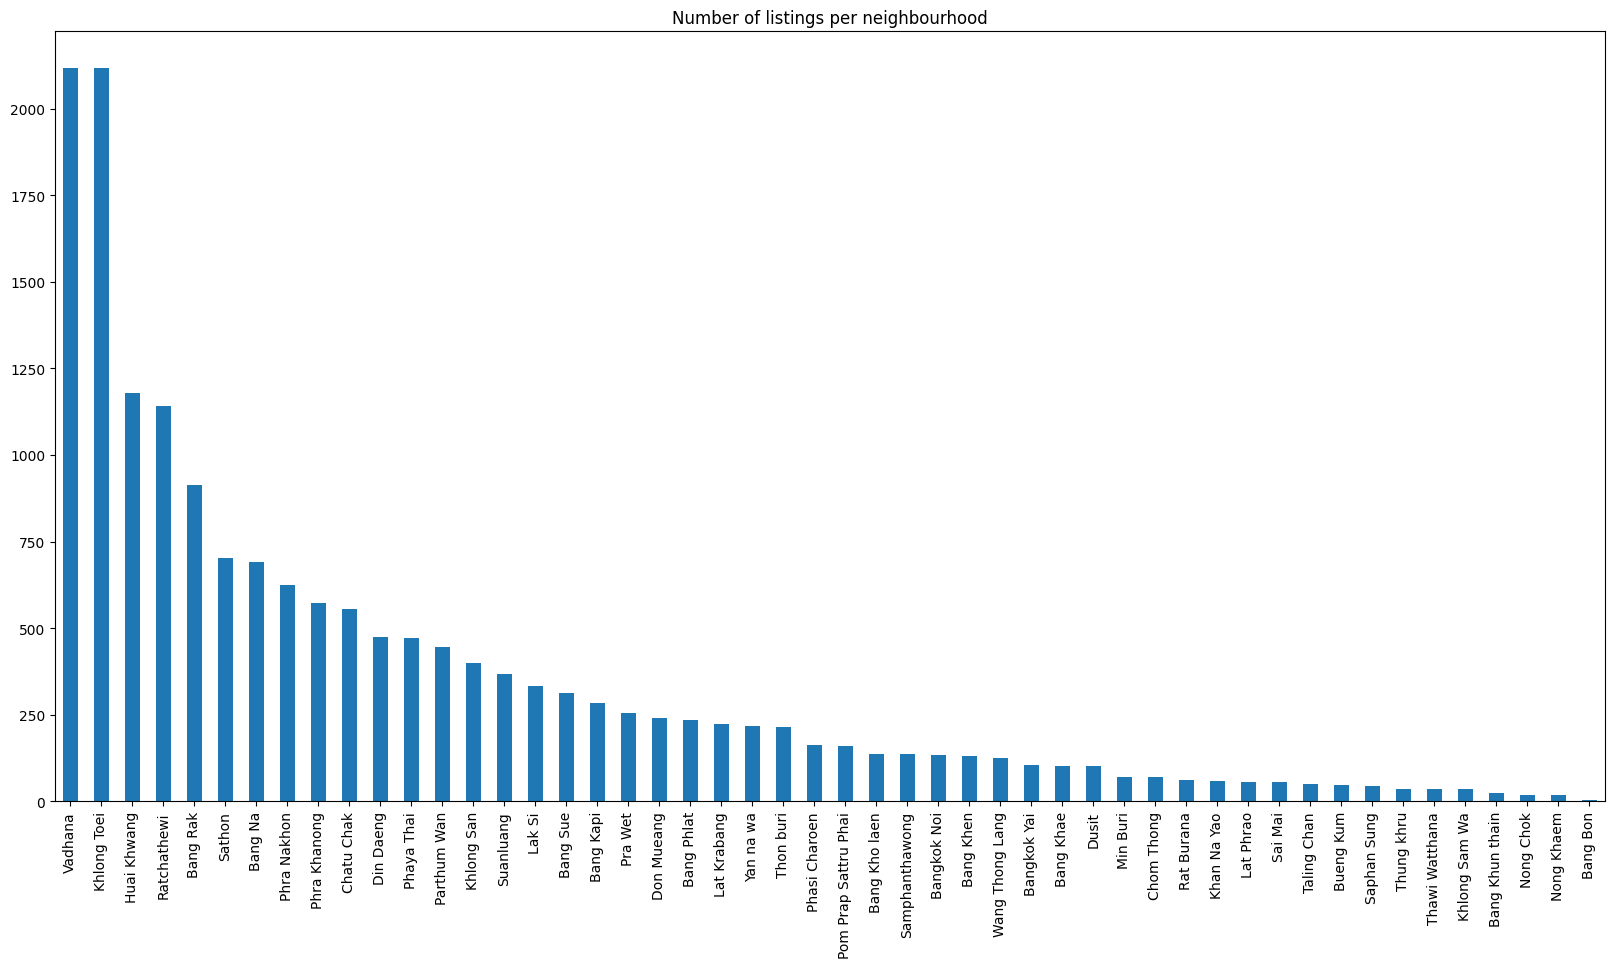

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

listing["neighbourhood"].value_counts().plot(kind='bar', figsize=(20,10), title='Number of listings per neighbourhood')

<AxesSubplot: title={'center': 'Latitude distribution'}, ylabel='Frequency'>

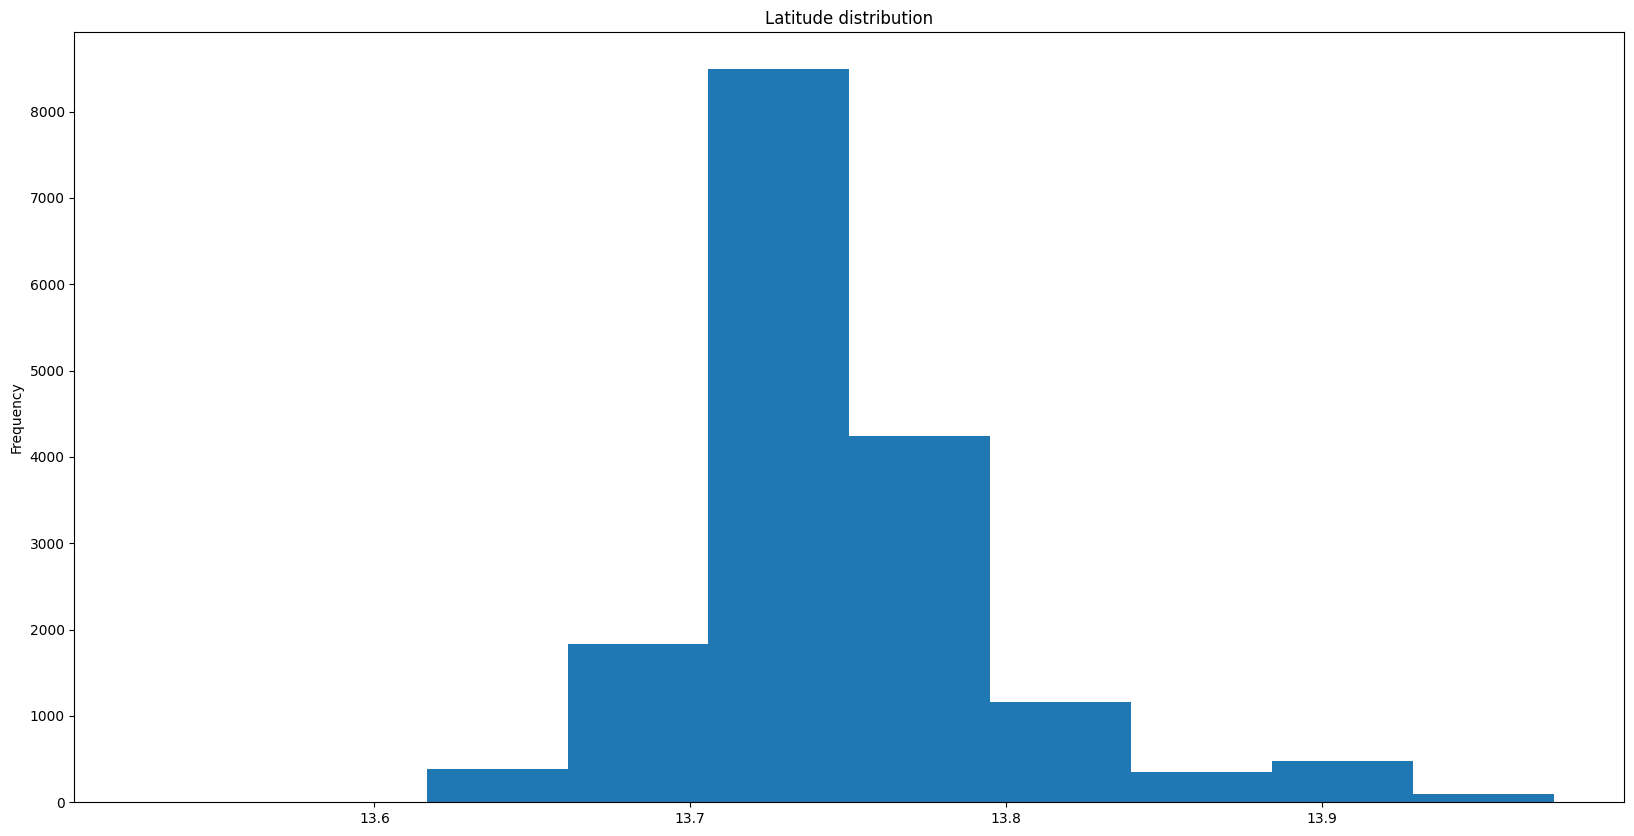

In [84]:
listing["latitude"].plot(kind='hist', figsize=(20,10), title='Latitude distribution')

<AxesSubplot: title={'center': 'Longitude Distribution'}, ylabel='Frequency'>

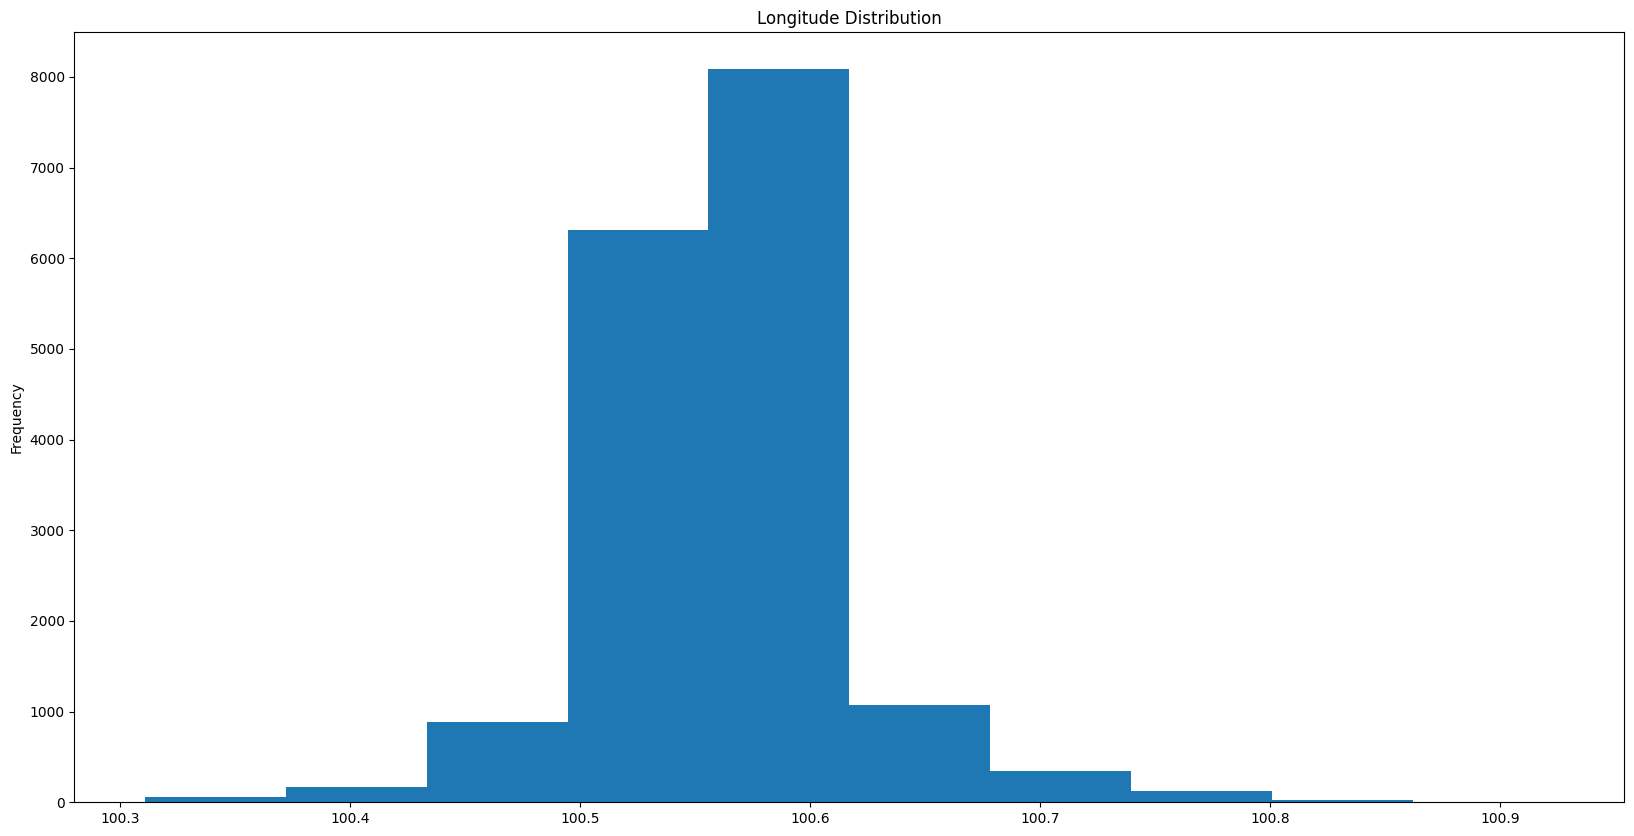

In [85]:
listing["longitude"].plot(kind="hist", figsize=(20,10), title='Longitude Distribution')

<AxesSubplot: title={'center': 'Number of listings per property type'}>

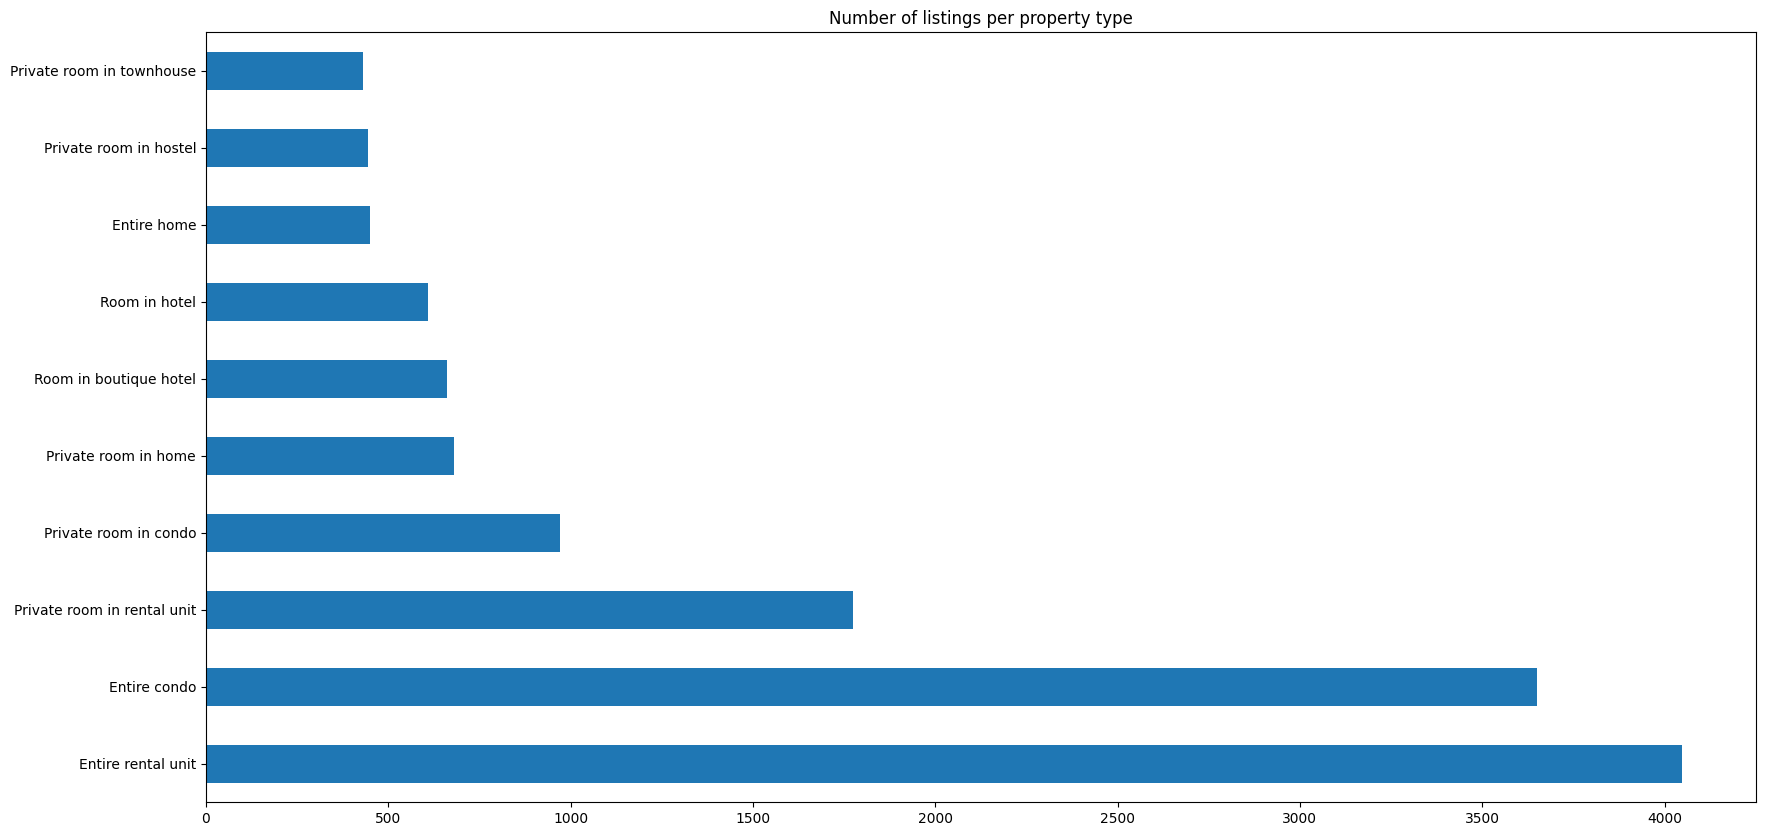

In [86]:
listing["property_type"].value_counts().head(10).plot(kind='barh', figsize=(20,10), title='Number of listings per property type')

<AxesSubplot: title={'center': 'Number of listings per number of accommodates'}>

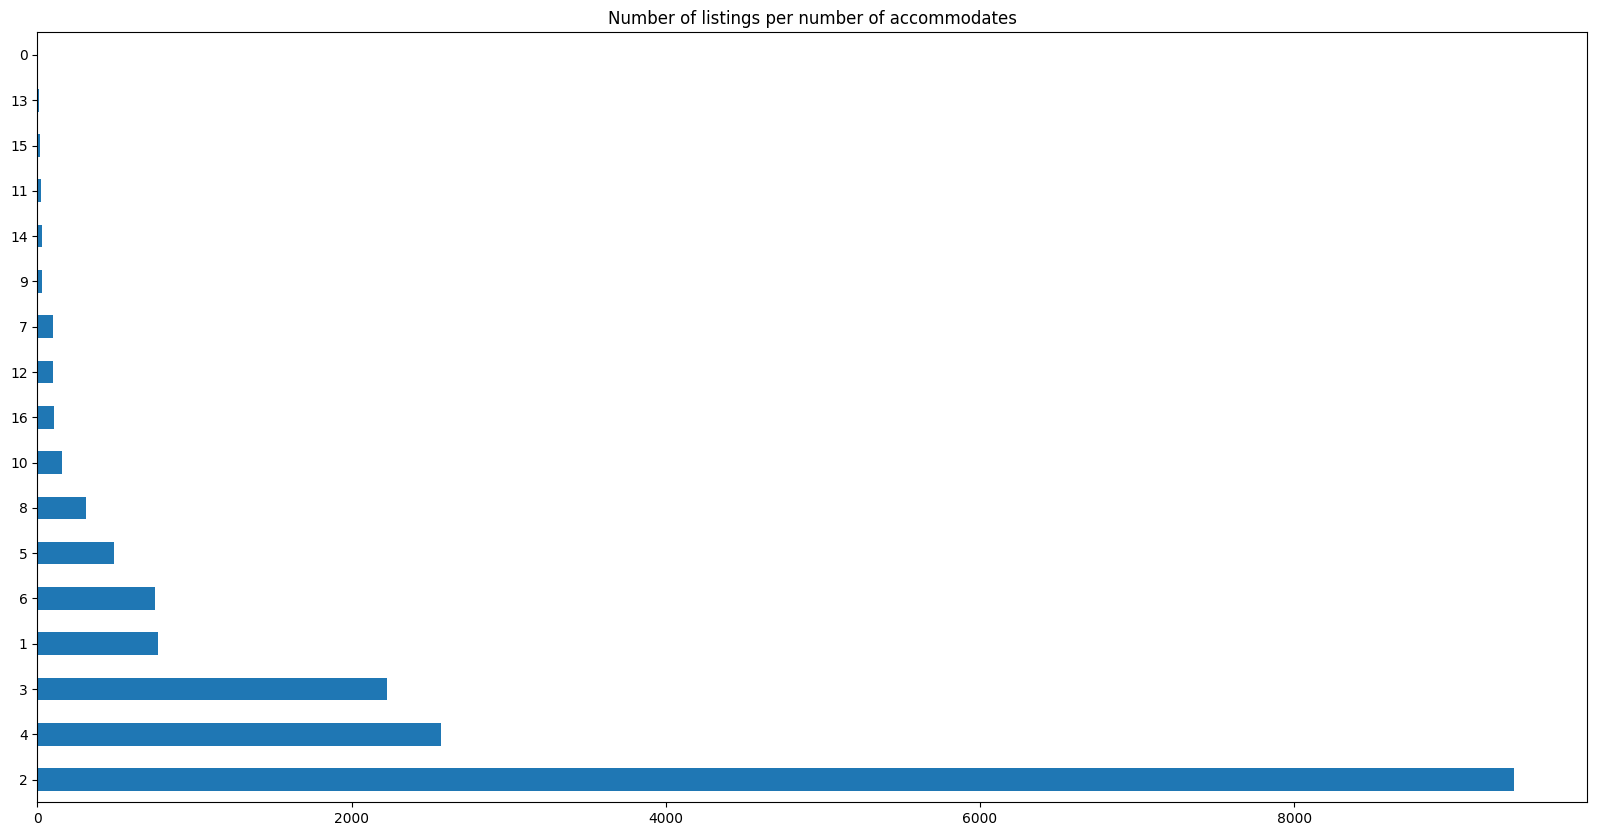

In [87]:
listing["accommodates"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of listings per number of accommodates')

<AxesSubplot: title={'center': 'Number of listings per number of bedrooms'}>

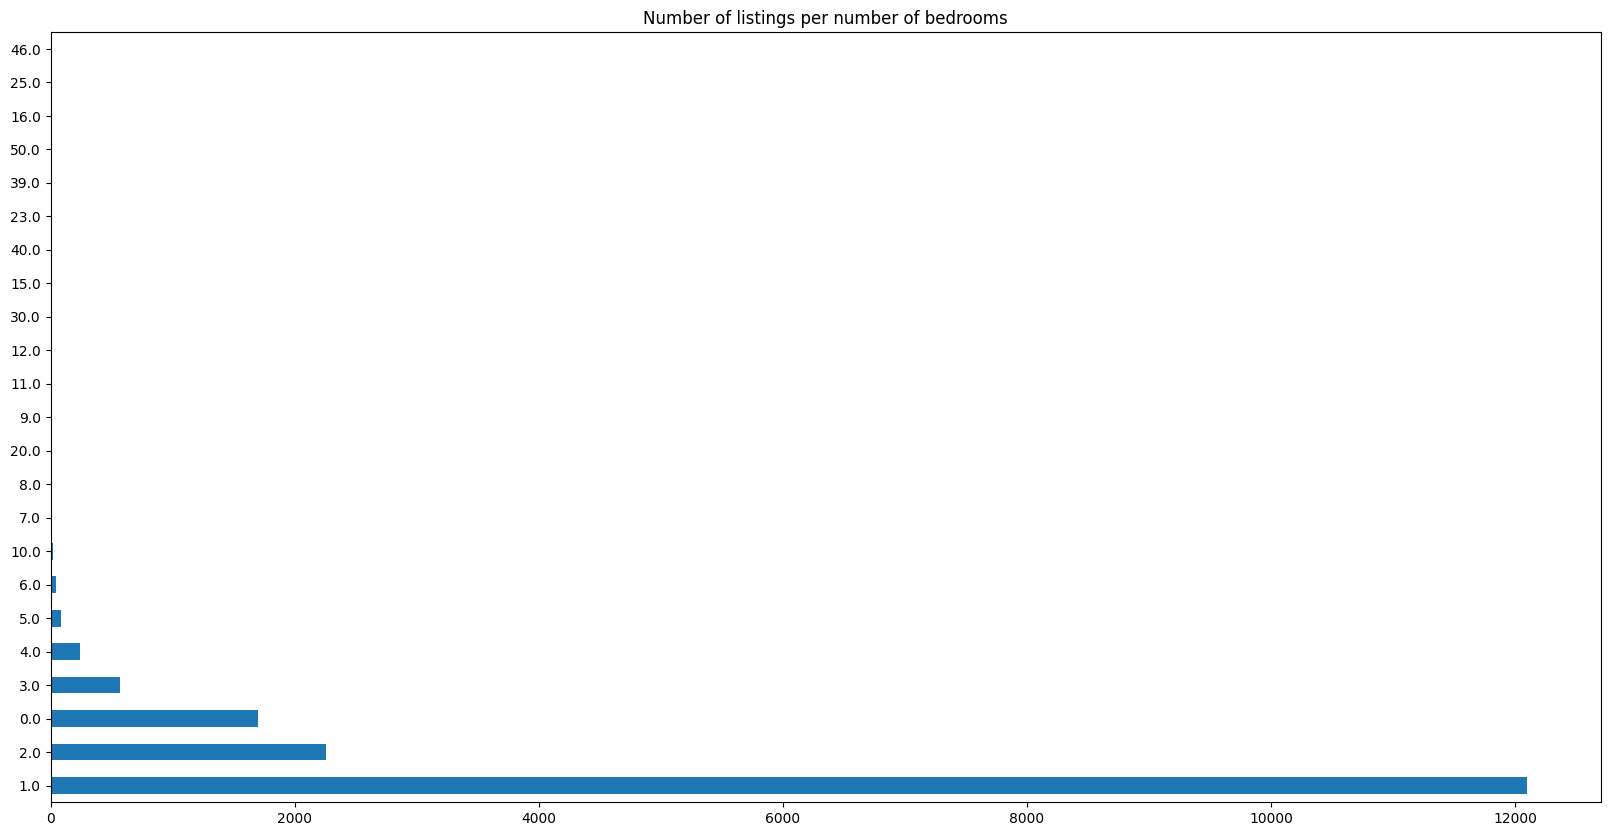

In [88]:
listing["bedrooms"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of listings per number of bedrooms')

<AxesSubplot: title={'center': 'Number of listings per number of beds'}>

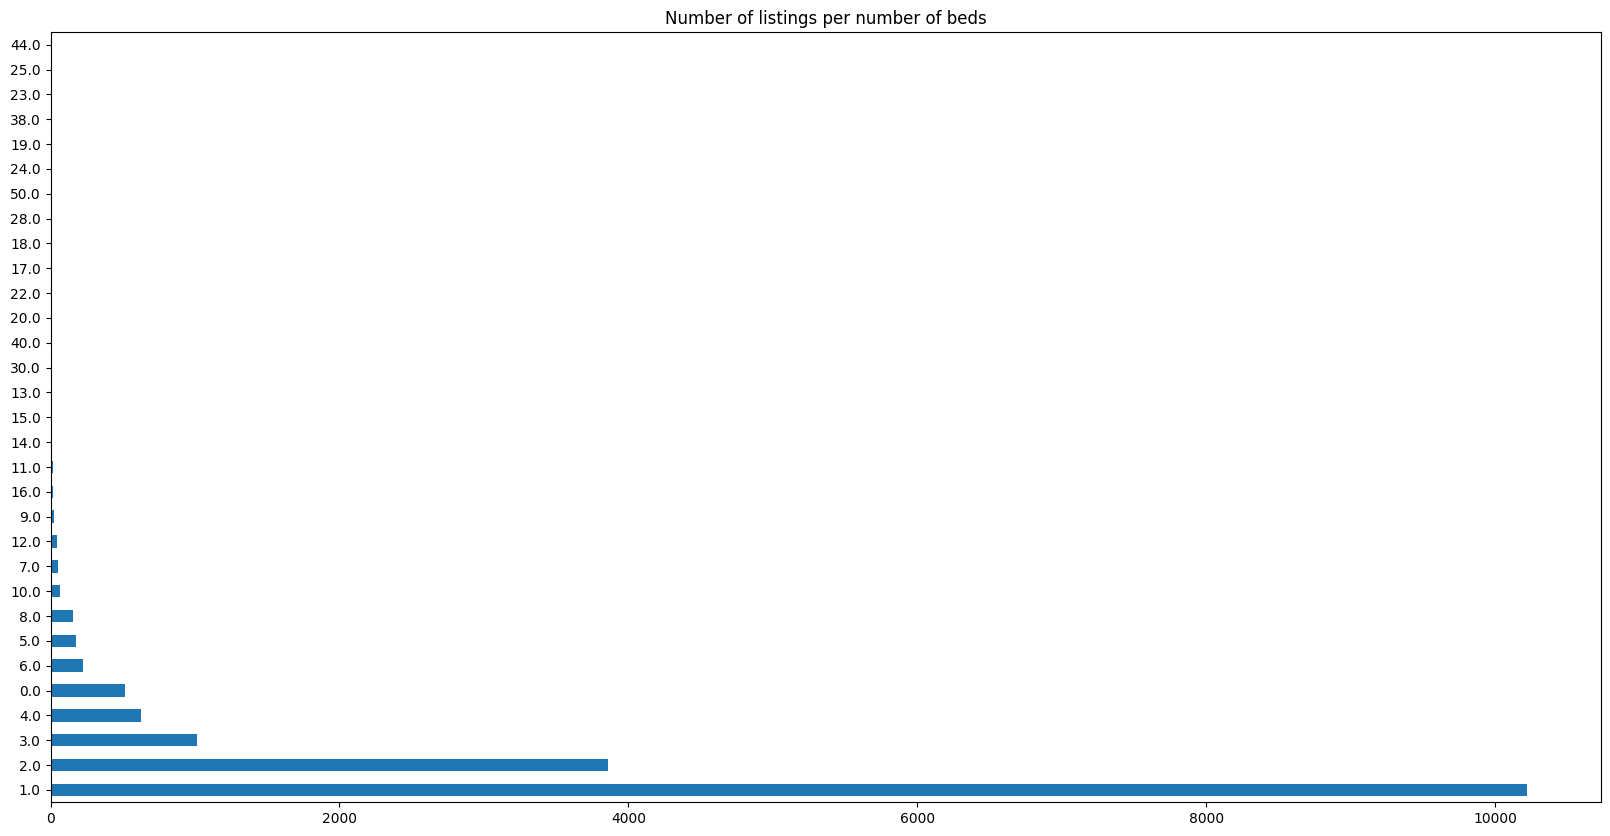

In [89]:
listing["beds"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of listings per number of beds')

<AxesSubplot: title={'center': 'Response rate distribution'}, ylabel='Frequency'>

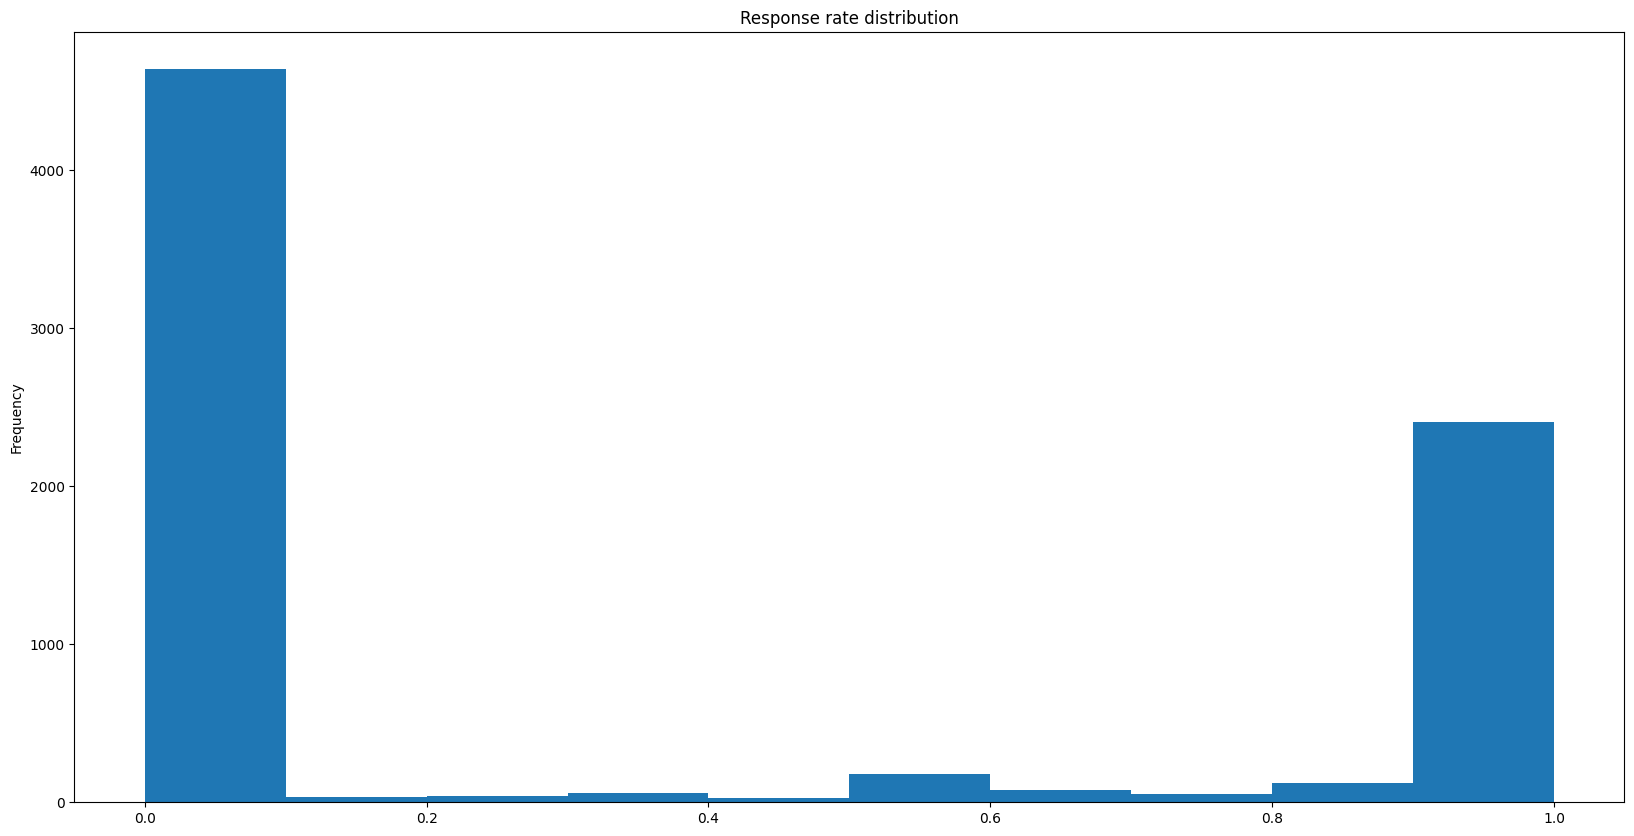

In [90]:
host["response_rate"].plot(kind='hist', figsize=(20,10), title='Response rate distribution')

<AxesSubplot: title={'center': 'Acceptance rate distribution'}, ylabel='Frequency'>

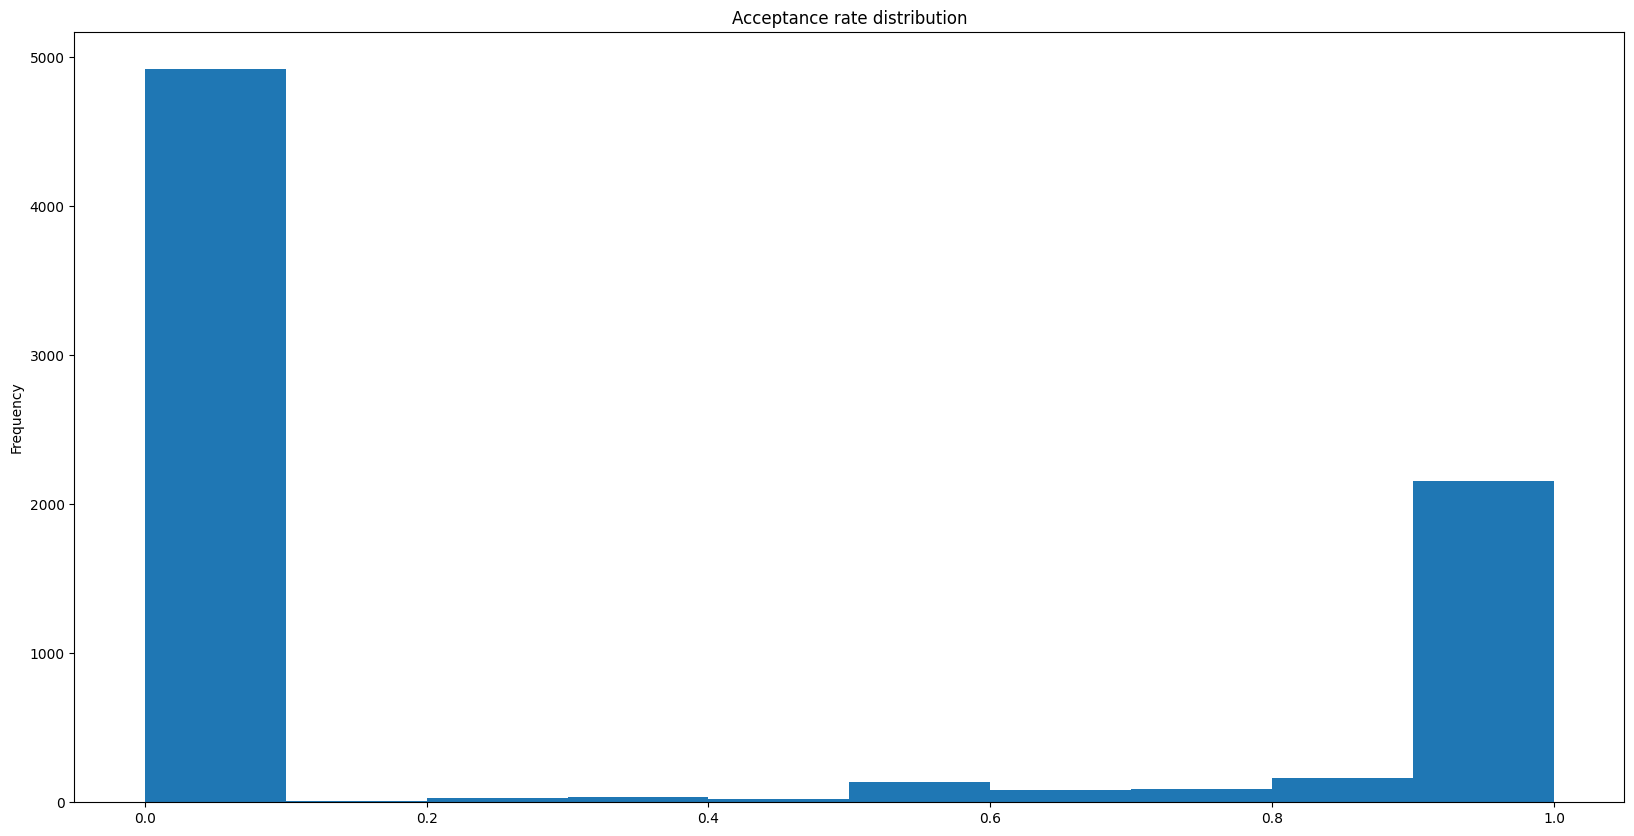

In [91]:
host["acceptance"].plot(kind='hist', figsize=(20,10), title='Acceptance rate distribution')

<AxesSubplot: title={'center': 'Number of super hosts'}>

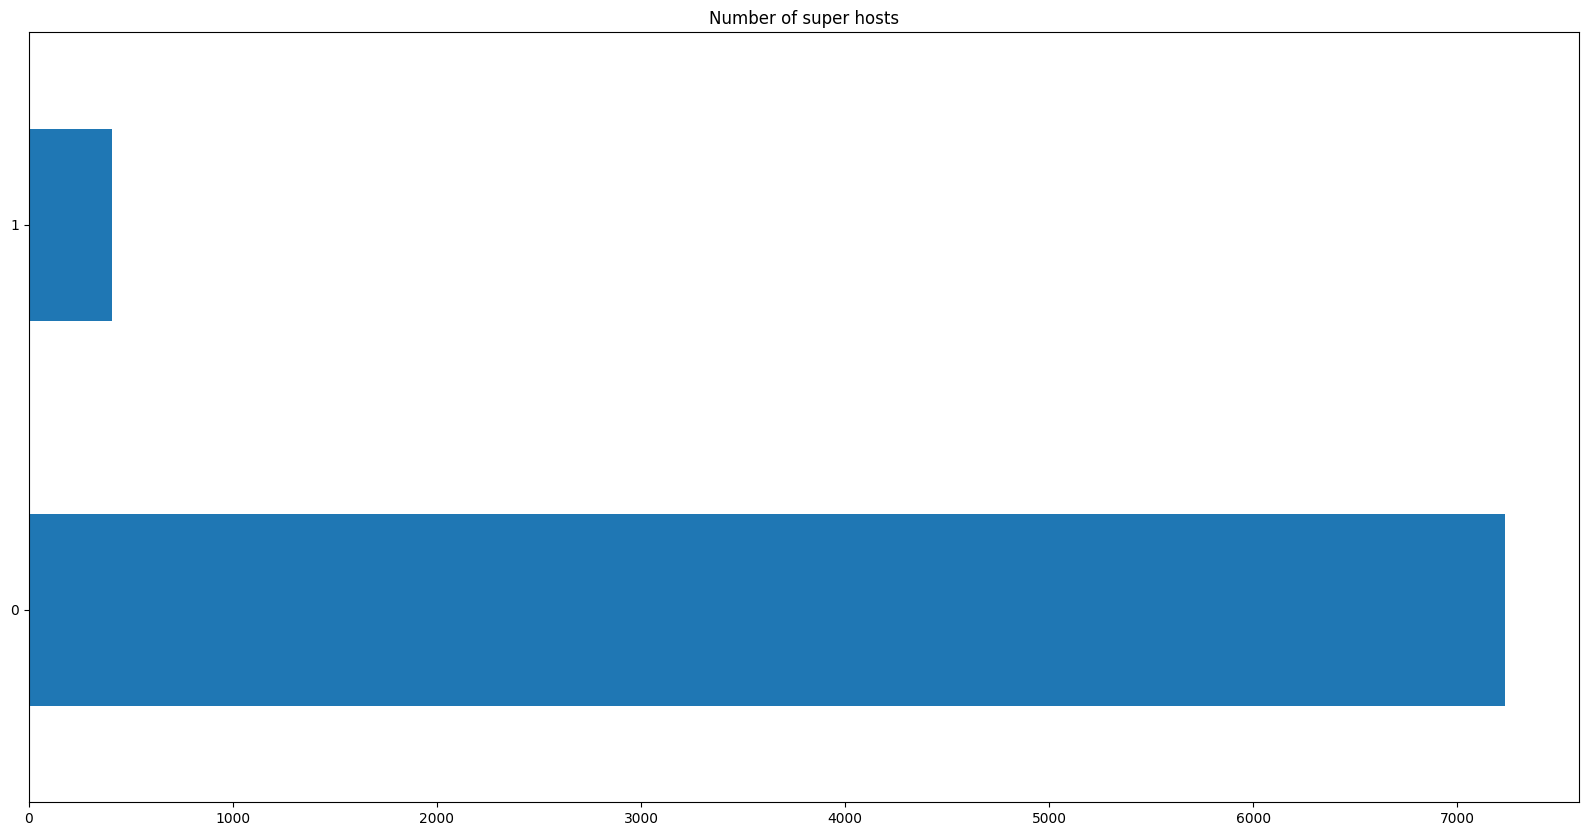

In [92]:
host["is_super_host"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of super hosts')

<AxesSubplot: title={'center': 'Number of hosts with email verified'}>

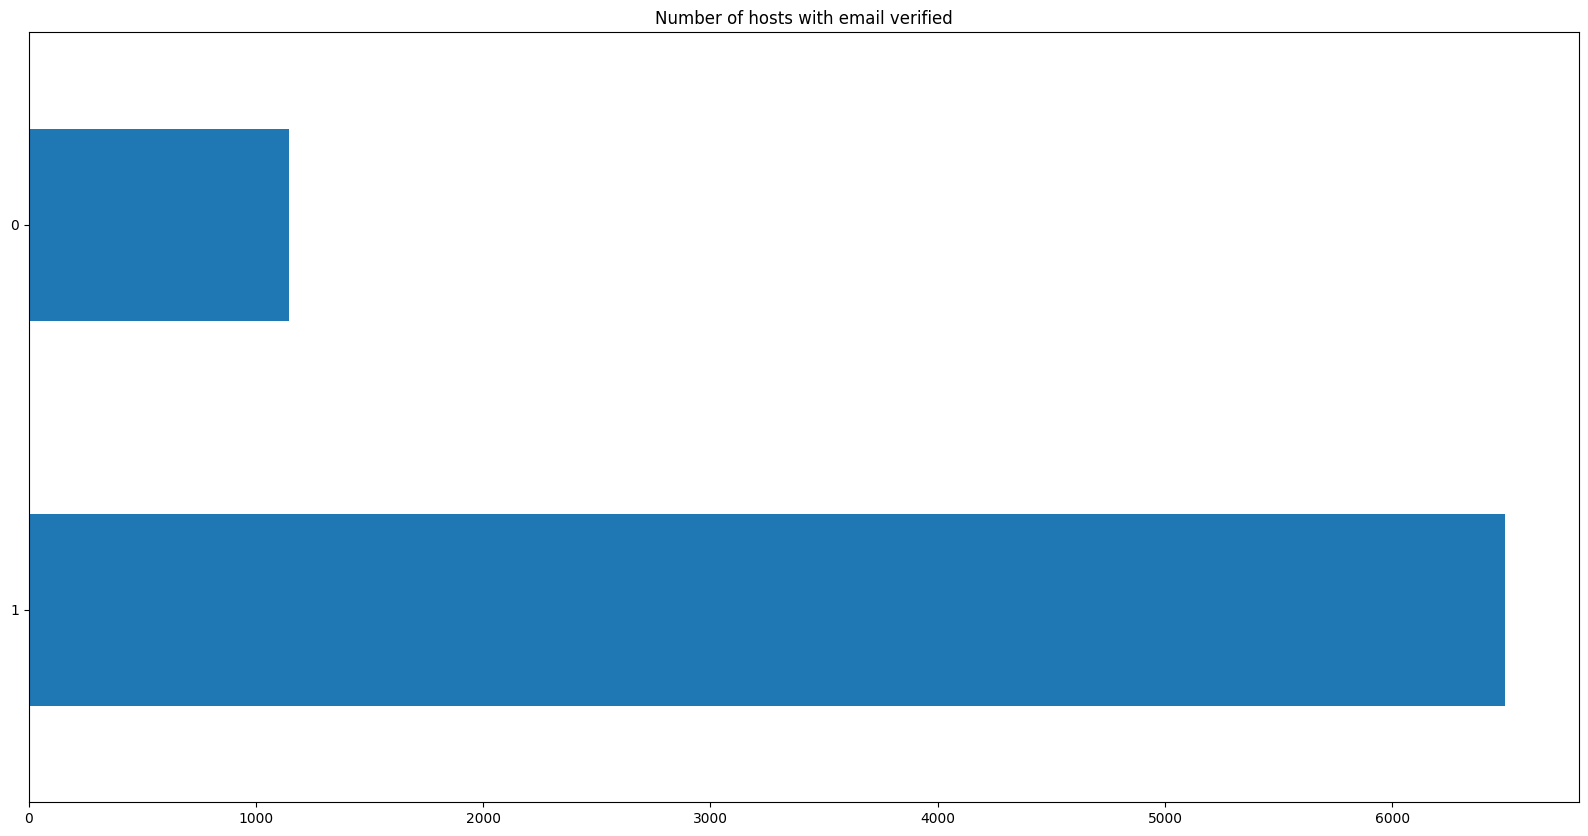

In [93]:
host["email_verified"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of hosts with email verified')

<AxesSubplot: title={'center': 'Number of hosts with phone verified'}>

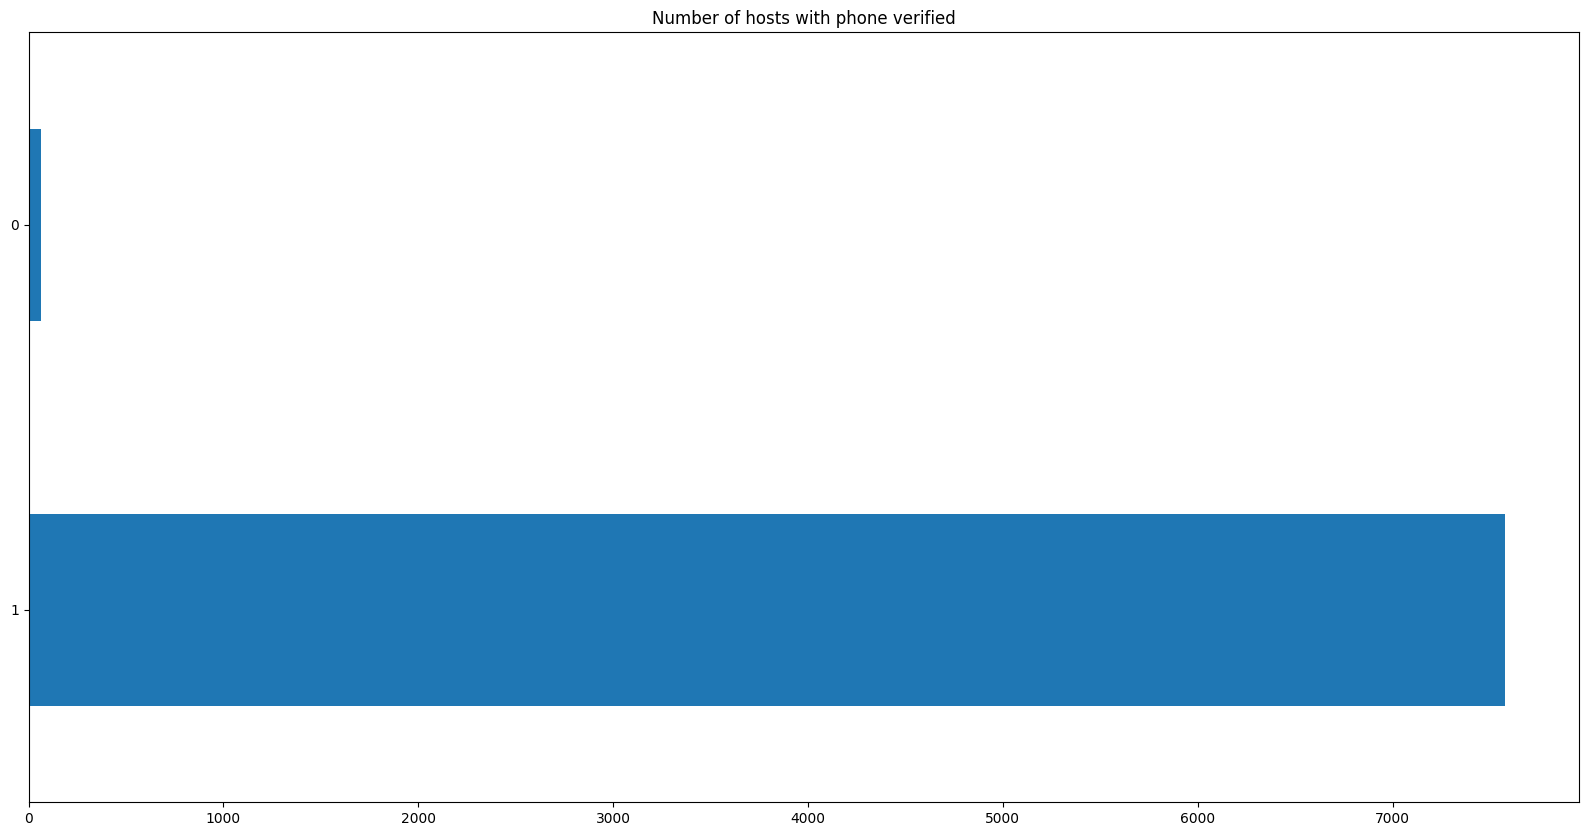

In [94]:
host["phone_verified"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of hosts with phone verified')

<AxesSubplot: title={'center': 'Number of hosts with work email verified'}>

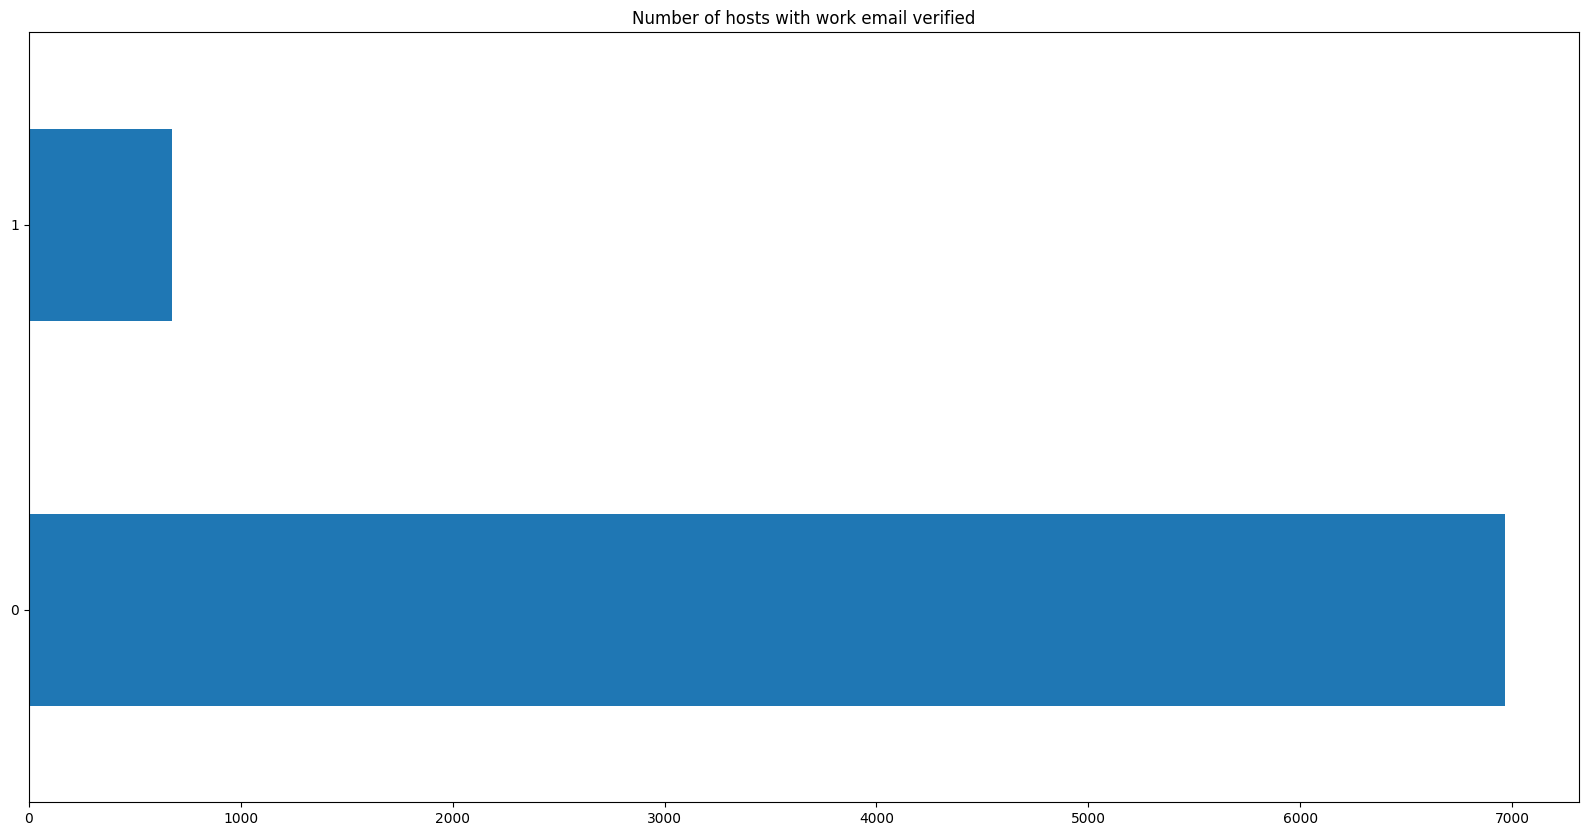

In [95]:
host["work_email_verified"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of hosts with work email verified')

<AxesSubplot: title={'center': 'Number of hosts with identity verified'}>

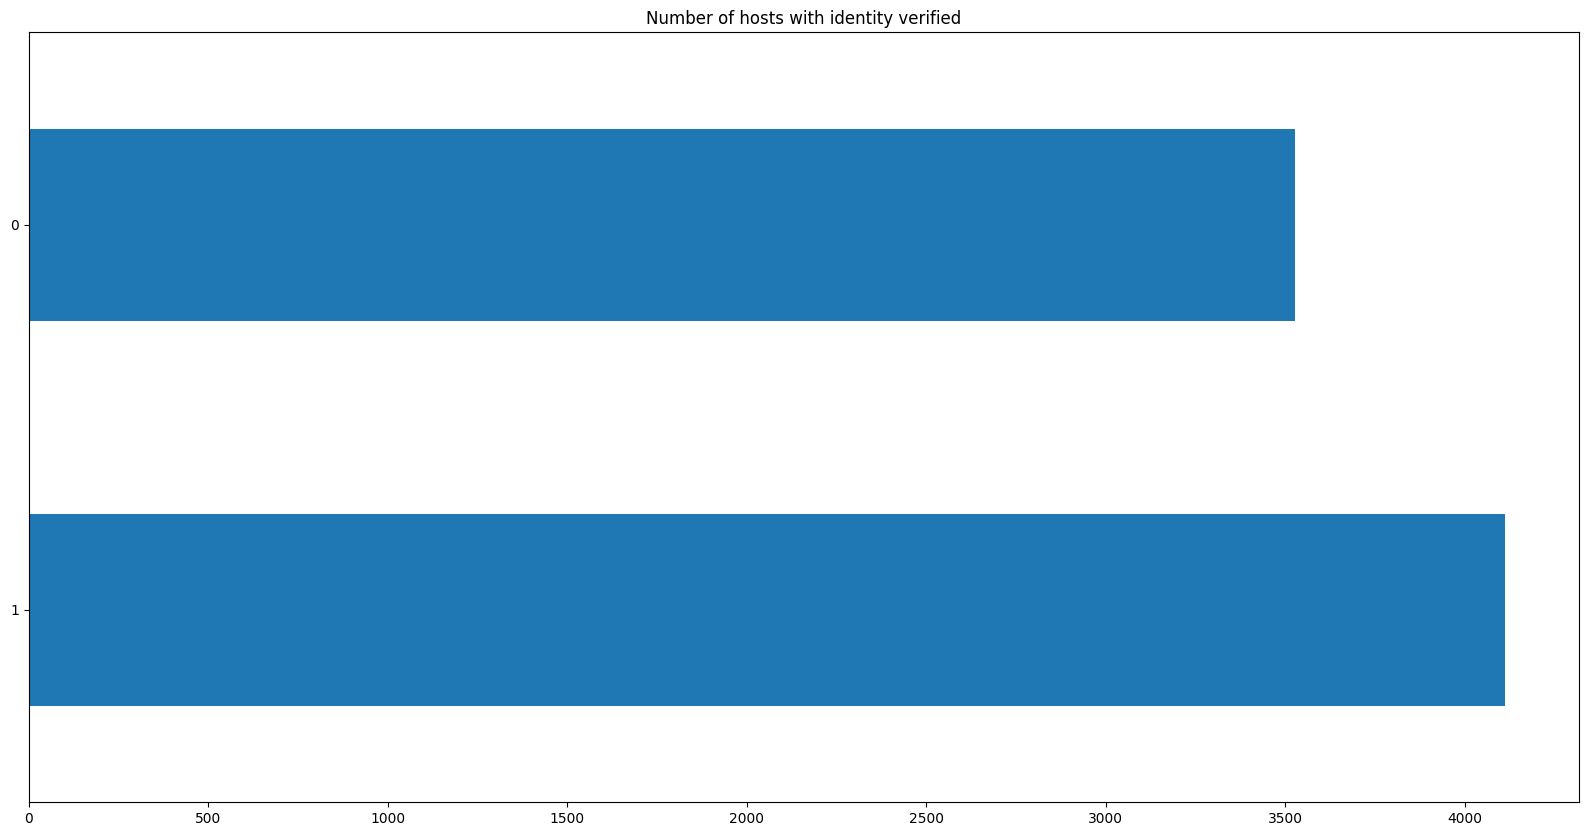

In [96]:
host["identity_verified"].value_counts().plot(kind='barh', figsize=(20,10), title='Number of hosts with identity verified')

<AxesSubplot: title={'center': 'Total price distribution'}, ylabel='Frequency'>

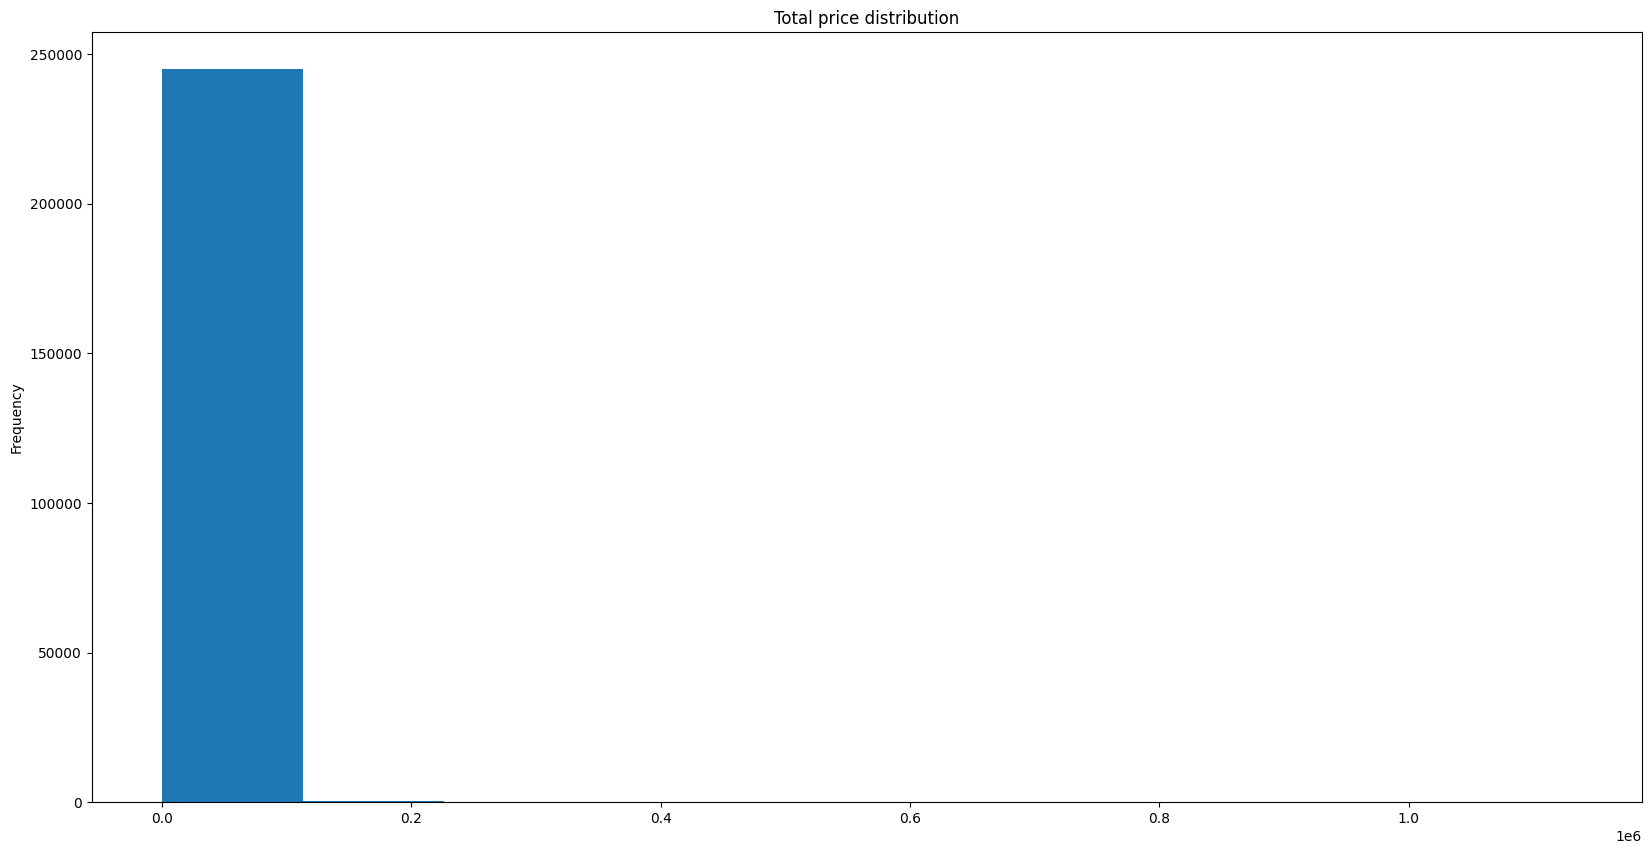

In [97]:
transaction["total_price"].plot(kind='hist', figsize=(20,10), title='Total price distribution')

<AxesSubplot: title={'center': 'Price distribution'}, ylabel='Frequency'>

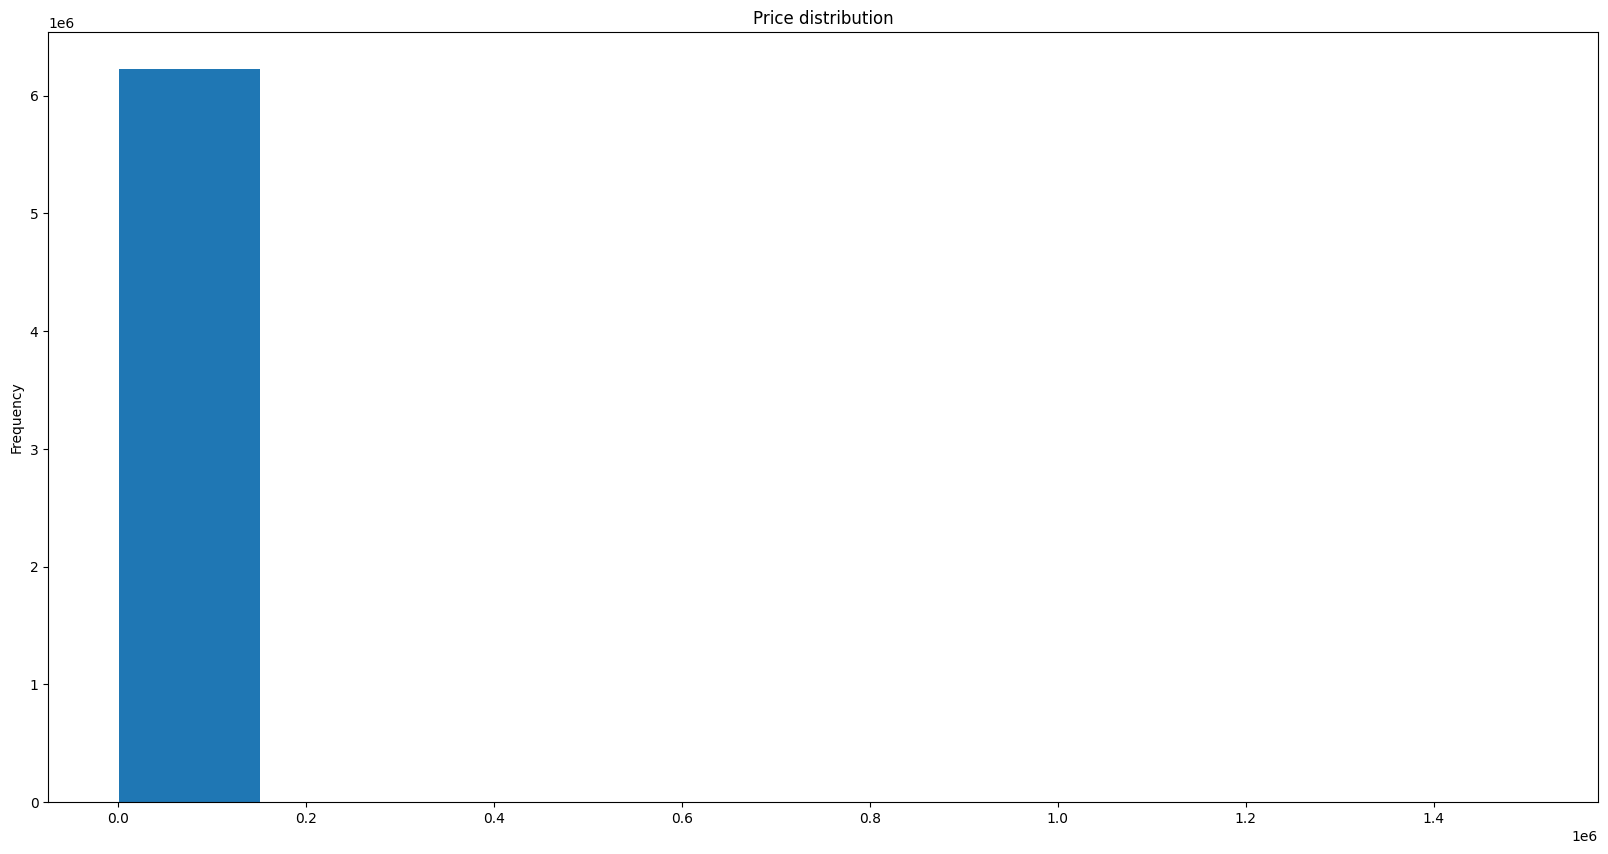

In [98]:
calendar["price"].plot(kind='hist', figsize=(20,10), title='Price distribution')

<AxesSubplot: title={'center': 'Adjusted price distribution'}, ylabel='Frequency'>

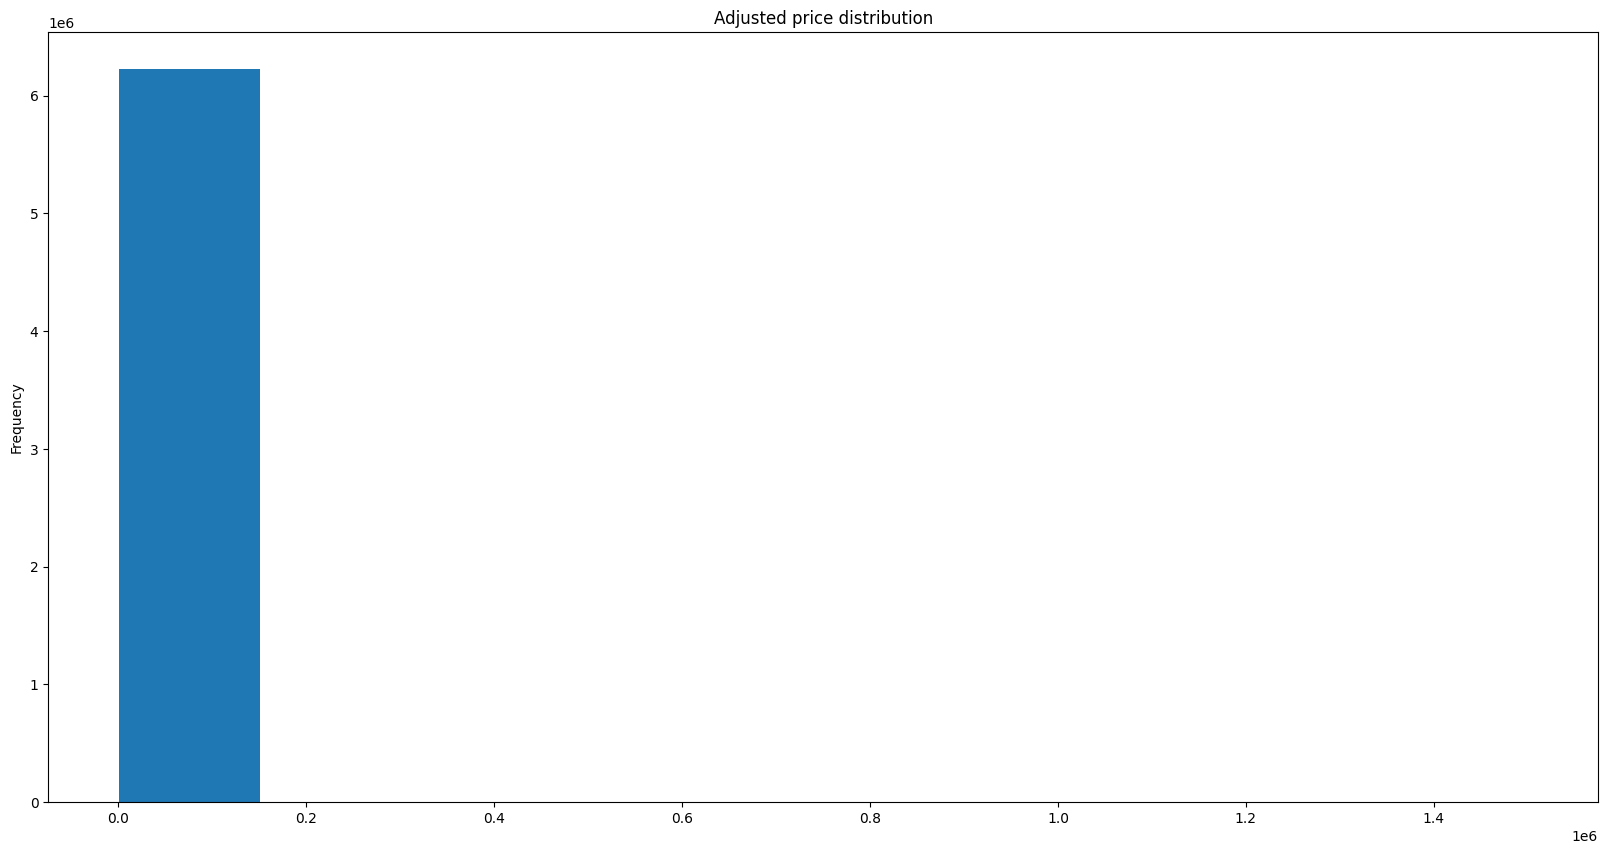

In [99]:
calendar["adjusted_price"].plot(kind='hist', figsize=(20,10), title='Adjusted price distribution')